In [17]:
from sklearn.preprocessing import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.regularizers import l1, l2
# from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import sklearn
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
def to_cat(y, num_cats):
    res = []
    for i in range(y.shape[0]):
        label = [0]*num_cats
        label[y[i]] = 1
        res.append(label)
    return np.array(res)

In [3]:
def accuracy(y_pred, y):
    num_correct = 0
    for i in range(y_pred.shape[0]):
        num_correct += y_pred[i].argmax() == y[i].argmax()
    return num_correct / y_pred.shape[0]

# Load and Scale Data

In [4]:
pddata_train = pd.read_csv('Data/sign_mnist_train.csv')
data_train = pddata_train.values
data_train_X = data_train[:,1:]
data_train_y = data_train[:,:1].reshape(-1) # turn to 1d
data_train_y = to_cat(data_train_y, 26)

test_size = 0.1
test_ind = int(test_size*data_train_X.shape[0])
data_train_X, data_val_X, data_train_y, data_val_y = data_train_X[test_ind:], data_train_X[:test_ind],data_train_y[test_ind:], data_train_y[:test_ind]


pddata_test = pd.read_csv('Data/sign_mnist_test.csv')
data_test = pddata_test.values
data_test_X = data_test[:, 1:]
data_test_y = data_test[:, :1].reshape(-1) # turn to 1d
data_test_y = to_cat(data_test_y, 26)

# scaler = StandardScaler()
# scaled_train_X = scaler.fit_transform(data_train_X)
# scaled_test_X = scaler.transform(data_test_X)

In [5]:
data_test_X.shape

(7172, 784)

In [6]:
print(f"There are {data_train_X.shape[0]} training samples")
print(f"There are {data_test_X.shape[0]} training samples")

There are 24710 training samples
There are 7172 training samples


# Dense Neural Network

In [6]:
def create_dnn(num_input, layers, activations, dropouts, regularizations, optimizer):
    model = Sequential()
    model.add(Input(shape=(num_input,)))
    for num_nodes, act, dr, reg in zip(layers, activations, dropouts, regularizations):
        model.add(Dense(num_nodes, activation=act, kernel_regularizer=reg))
        if dr != 0:
            model.add(Dropout(dr))
            
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Testing Dense Neural Network

In [7]:
# layers = [26]
# activations = ['softmax']
# dropouts=[0, 0, 0, 0]
# optimizer=Adam(0.01)
# regularizations = [
#     l2(0.01)
# ]
# epochs=200
# batch_size=256

# early_stop = EarlyStopping(
#     monitor="loss",
#     min_delta=0,
#     patience=10,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
# )

# model = create_dnn(data_train_X[0].shape[0], layers, activations, dropouts, regularizations, optimizer)

# model.summary()

# model.fit(data_train_X, data_train_y, validation_data=(data_val_X, data_val_y), epochs=epochs, batch_size=batch_size, verbose=1)

In [8]:
# model.evaluate(data_test_X, data_test_y)

# Convolutional Neural Network

## Loading Data

In [14]:
pddata_train = pd.read_csv('Data/sign_mnist_train.csv')
data_train = pddata_train.values
data_train_X = data_train[:,1:]
data_train_X = data_train_X.reshape((data_train_X.shape[0], 28,28,1))
data_train_y = data_train[:,:1].reshape(-1) # turn to 1d
data_train_y = to_cat(data_train_y, 26)

test_size = 0.1
test_ind = int(test_size*data_train_X.shape[0])
data_train_X, data_val_X, data_train_y, data_val_y = data_train_X[test_ind:], data_train_X[:test_ind],data_train_y[test_ind:], data_train_y[:test_ind]


pddata_test = pd.read_csv('Data/sign_mnist_test.csv')
data_test = pddata_test.values
data_test_X = data_test[:, 1:]
data_test_X = data_test_X.reshape((data_test_X.shape[0], 28,28,1))
data_test_y = data_test[:, :1].reshape(-1) # turn to 1d
data_test_y = to_cat(data_test_y, 26)

# scaler = StandardScaler()
# scaled_train_X = scaler.fit_transform(data_train_X)
# scaled_test_X = scaler.transform(data_test_X)

In [38]:
import visualkeras
from PIL import ImageFont
example = create_cnn((28,28,1), Adam(1), l2(0))
font = ImageFont.truetype("arial.ttf", 10)
visualkeras.layered_view(example, legend=True, font=font, to_file='./Figures//CNN//architecture.png').show()

In [31]:
def create_cnn(input_shape, optimizer, regularizer):
    model = Sequential()
    spacing=20
    model.add(Input(shape=input_shape))
    model.add(Conv2D(8, 3, activation='selu', padding='same', kernel_initializer=GlorotNormal(seed=42)))
    model.add(visualkeras.SpacingDummyLayer(spacing=spacing))
    model.add(MaxPooling2D(2))
    model.add(visualkeras.SpacingDummyLayer(spacing=spacing))
    model.add(Conv2D(4, 2, activation='selu', padding='same', kernel_initializer=GlorotNormal(seed=42)))
    model.add(visualkeras.SpacingDummyLayer(spacing=spacing))
    model.add(MaxPooling2D(2))
    model.add(visualkeras.SpacingDummyLayer(spacing=spacing))
    model.add(Flatten())
    model.add(visualkeras.SpacingDummyLayer(spacing=spacing))
    model.add(Dropout(0.5))
    model.add(visualkeras.SpacingDummyLayer(spacing=spacing))
    model.add(Dense(26, activation='softmax', kernel_regularizer=regularizer, kernel_initializer=GlorotNormal(seed=42)))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [8]:
def run_model(lr, batch_size, epochs, reg, X_train = data_train_X, y_train = data_train_y, X_test = data_test_X, y_test = data_test_y):
    model = create_cnn((28, 28,1), Adam(lr), reg)

    early_stop = EarlyStopping(
        monitor="loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], verbose=0)
    
    results = model.evaluate(X_test, y_test)
    return results[1]

## Testing Different Learning Rates

In [8]:
lr = np.logspace(-3, -0.5, 11)
acc = []
for l in lr:
    acc.append(run_model(l, 256, 200, l2(0)))

7172/7172 [==============================] - 0s 59us/sample - loss: 37.8533 - accuracy: 0.0436


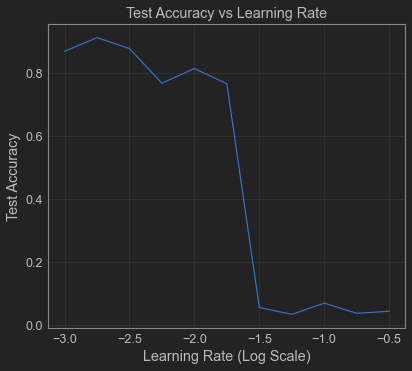

In [16]:
plt.plot(np.linspace(-3, -0.5,11), acc)
plt.xlabel('Learning Rate (Log Scale)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Learning Rate')
name = "CNN test vs lr"
plt.savefig(f'Figures\\CNN\\{name}.jpg', dpi=500)
plt.plot()

pd.DataFrame([np.linspace(-3, -0.5,11), acc], index=['learning rate', 'accuracy']).transpose().to_csv(f'./Figures/CNN/{name}.csv')

## Testing Different Learning Batch Sizes

In [7]:
batches = [4, 8, 16, 32, 64, 128, 256, 512, 1024]
acc = []
for b in batches:
    acc.append(run_model(0.002, b, 200, l2(0)))

7172/7172 [==============================] - 0s 59us/sample - loss: 0.4908 - accuracy: 0.8463


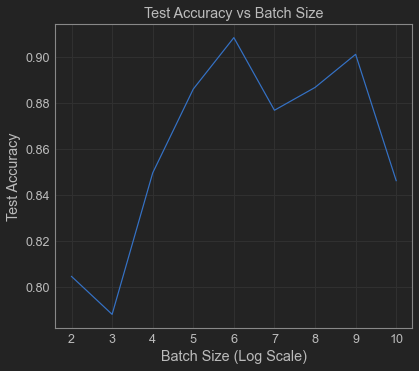

In [10]:
plt.plot(list(range(2,11)), acc)
plt.xlabel('Batch Size (Log Scale)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Batch Size')
name = "CNN test vs batch size"
plt.savefig(f'Figures\\CNN\\{name}.jpg', dpi=500)
plt.plot()

pd.DataFrame([list(range(2,11)), acc], index=['batch size (log)', 'accuracy']).transpose().to_csv(f'./Figures/CNN/{name}.csv')

## Testing Different Lambdas for l1 Regularization

In [11]:
lamb = [0]+list(np.logspace(-3, -0.5, 11))
acc = []
for l in lamb:
    acc.append(run_model(0.002, 256, 200, l1(l)))

7172/7172 [==============================] - 0s 60us/sample - loss: 3.6140 - accuracy: 0.0201


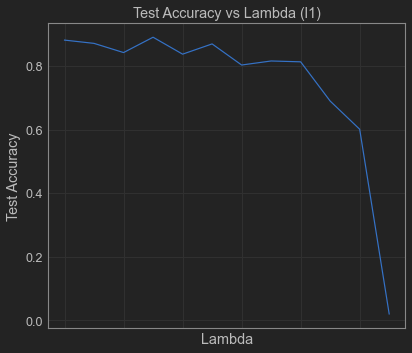

In [13]:
plt.plot(acc)
plt.xlabel('Lambda')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Lambda (l1)')

plt.tick_params(
    axis='x',  
    which='both',   
    bottom=False,  
    top=False,     
    labelbottom=False)

name = "CNN test vs lambda (l1)"
plt.savefig(f'Figures\\CNN\\{name}.jpg', dpi=500)
plt.plot()

pd.DataFrame([lamb, acc], index=['lambda (l1)', 'accuracy']).transpose().to_csv(f'./Figures/CNN/{name}.csv')

## Testing Different Lambdas for l2 Regularization

In [16]:
lamb = [0]+list(np.logspace(-3, -0.5, 11))
acc = []
for l in lamb:
    acc.append(run_model(0.002, 256, 200, l2(l)))

7172/7172 [==============================] - 0s 54us/sample - loss: 0.7492 - accuracy: 0.8429


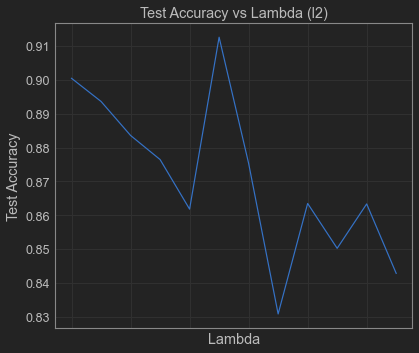

In [18]:
plt.plot(acc)
plt.xlabel('Lambda')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Lambda (l2)')

plt.tick_params(
    axis='x',  
    which='both',   
    bottom=False,  
    top=False,     
    labelbottom=False)

name = "CNN test vs lambda (l2)"
plt.savefig(f'Figures\\CNN\\{name}.jpg', dpi=500)
plt.plot()

pd.DataFrame([lamb, acc], index=['lambda (l2)', 'accuracy']).transpose().to_csv(f'./Figures/CNN/{name}.csv')

In [30]:
pd.DataFrame([lamb, acc]).transpose().to_csv('Figures\\CNN test vs lambda l1.csv')

## Testing Different Scalings

In [9]:
pddata_train = pd.read_csv('Data/sign_mnist_train.csv')
data_train = pddata_train.values
data_train_X = data_train[:,1:]
data_train_y = data_train[:,:1].reshape(-1) # turn to 1d
data_train_y = to_cat(data_train_y, 26)

test_size = 0.1
test_ind = int(test_size*data_train_X.shape[0])
data_train_X, data_val_X, data_train_y, data_val_y = data_train_X[test_ind:], data_train_X[:test_ind],data_train_y[test_ind:], data_train_y[:test_ind]


pddata_test = pd.read_csv('Data/sign_mnist_test.csv')
data_test = pddata_test.values
data_test_X = data_test[:, 1:]
data_test_y = data_test[:, :1].reshape(-1) # turn to 1d
data_test_y = to_cat(data_test_y, 26)

mmscaler = MinMaxScaler()
mmscaled_train_X = mmscaler.fit_transform(data_train_X)
mmscaled_test_X = mmscaler.transform(data_test_X)

stdscaler = StandardScaler()
stdscaled_train_X = stdscaler.fit_transform(data_train_X)
stdscaled_test_X = stdscaler.transform(data_test_X)

mmscaled_train_X = mmscaled_train_X.reshape((mmscaled_train_X.shape[0], 28,28,1))
mmscaled_test_X = mmscaled_test_X.reshape((mmscaled_test_X.shape[0], 28,28,1))
stdscaled_train_X = stdscaled_train_X.reshape((stdscaled_train_X.shape[0], 28,28,1))
stdscaled_test_X = stdscaled_test_X.reshape((stdscaled_test_X.shape[0], 28,28,1))
data_train_X = data_train_X.reshape((data_train_X.shape[0], 28,28,1))
data_test_X = data_test_X.reshape((data_test_X.shape[0], 28,28,1))

In [39]:
run_model(0.002, 256, 200, l2(0), X_train=data_train_X, X_test=data_test_X)

run_model(0.002, 256, 200, l2(0), X_train=mmscaled_train_X, X_test=mmscaled_test_X)

run_model(0.002, 256, 200, l2(0), X_train=stdscaled_train_X, X_test=stdscaled_test_X)

7172/7172 [==============================] - 0s 53us/sample - loss: 0.2603 - accuracy: 0.9226


0.9226157